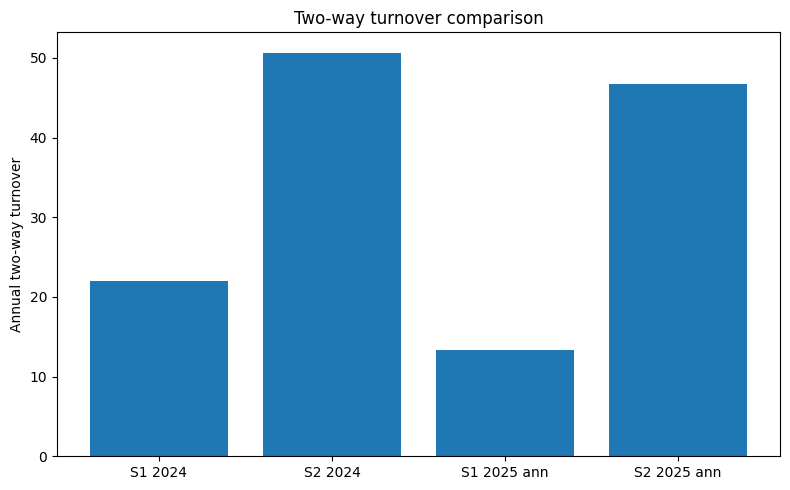

(        date ticker         z
 0 2024-02-01  T3070 -1.208298
 1 2024-02-01  T4566  0.963493
 2 2024-02-02  T2966 -0.277321
 3 2024-02-05  T0278  0.102075
 4 2024-02-05  T0479  0.094279
 5 2024-02-05  T0671  0.817037
 6 2024-02-05  T0786  0.033595
 7 2024-02-05  T0834 -0.994559
 8 2024-02-05  T0960 -0.703524
 9 2024-02-05  T1196 -0.445003,
 'simulated_earnings_events_2024_2025.csv',
 'daily_two_way_turnover.csv')

In [29]:
# Simulate earnings-call event data and compare annual two-way turnover for two strategies
# Period: 2024-01-01 to 2025-08-31
# Strategy 1: EWMA decay (alpha=0.5) with 10-business-day window; daily long top decile / short bottom decile among nonzero-signal names, equal-weighted; gross=1 each day.
# Strategy 2: Daily "sleeves": on each day, form a sleeve from THAT DAY's events only—long top decile / short bottom decile, equal-weighted within the sleeve; hold each sleeve for 10 business days; combine active sleeves and rescale to gross=1 daily.
#
# Outputs: summary table, daily turnover series, and downloadable CSVs.

import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import itertools
from datetime import datetime
import matplotlib.pyplot as plt

# --- Parameters ---
np.random.seed(42)
start_date = "2024-01-01"
end_date = "2025-08-31"
alpha = 0                # EWMA decay factor
lookback_days = 21*4         # business-day window for both strategies
num_of_sleeves = 10        # holding period for each sleeve
n_names = 5000              # universe size
tickers = [f"T{i:04d}" for i in range(1, n_names + 1)]

# Business days
biz_days = pd.bdate_range(start_date, end_date, freq="C", weekmask="Mon Tue Wed Thu Fri")
biz_day_index = pd.Index(biz_days)

# --- Helper: pick clustered event dates within target months ---
def clustered_bdays_in_month(year, month, idx=biz_day_index, center_day=15, sigma=4):
    days = pd.bdate_range(f"{year}-{month:02d}-01", pd.Timestamp(year=year, month=month, day=1) + pd.offsets.MonthEnd(0))
    if len(days) == 0:
        return None, None
    dom = np.array([d.day for d in days])
    # Gaussian-like weights centered near the middle of the month
    w = np.exp(-0.5 * ((dom - center_day) / sigma) ** 2)
    w = w / w.sum()
    return days, w

# Target earnings clusters
cluster_months = [(2024, 2), (2024, 5), (2024, 8), (2024, 11),
                  (2025, 2), (2025, 5), (2025, 8)]

# --- Simulate events: one per listed cluster month per ticker ---
rows = []
for t in tickers:
    for (yy, mm) in cluster_months:
        days, w = clustered_bdays_in_month(yy, mm)
        if days is None:
            continue
        # Sample ONE business day in that month for this ticker's call
        d = np.random.choice(days, p=w)
        z = np.random.normal(0, 1)  # already region/sector-neutral z-score
        rows.append((d, t, float(z)))

events = pd.DataFrame(rows, columns=["date", "ticker", "z"]).sort_values(["date", "ticker"]).reset_index(drop=True)
events = events[(events["date"] >= pd.Timestamp(start_date)) & (events["date"] <= pd.Timestamp(end_date))]

# Save simulated events
events_path = "simulated_earnings_events_2024_2025.csv"
events.to_csv(events_path, index=False)

# --- Build daily signals for Strategy 1 (EWMA-truncated window) ---
# For computational efficiency, build a sparse mapping from day -> list of (ticker, z) for events
events_by_day = events.groupby("date")

# Signals: DataFrame indexed by biz_days, columns = tickers, float
signals = pd.DataFrame(0.0, index=biz_days, columns=tickers)

# For each event, add decayed contributions for k=0..lookback_days-1
for d, g in events_by_day:
    if d not in signals.index:
        continue
    for _, row in g.iterrows():
        tkr = row["ticker"]
        z = row["z"]
        # Apply EWMA-style decay within a finite 10-day business window
        for k in range(lookback_days):
            day_k = d + BDay(k)
            if day_k in signals.index:
                signals.at[day_k, tkr] += ((1-alpha) ** k) * z

# --- Strategy 1 daily portfolio weights ---
def daily_weights_strategy1(day_signal: pd.Series, gross_target=1.0, decile=0.1):
    s = day_signal.copy()
    s = s[s != 0.0]  # consider only tickers with active nonzero signals
    if s.empty:
        return pd.Series(dtype=float)
    n = len(s)
    k = max(int(np.ceil(decile * n)), 1)
    # Rank
    s_sorted = s.sort_values()
    shorts = s_sorted.iloc[:k].index
    longs = s_sorted.iloc[-k:].index
    # Equal-weight within sides; gross split 50/50
    w = pd.Series(0.0, index=s.index)
    w.loc[longs] = (gross_target / 2.0) / k
    w.loc[shorts] = -(gross_target / 2.0) / k
    return w

weights_s1 = []
for d in biz_days:
    w = daily_weights_strategy1(signals.loc[d])
    weights_s1.append(w)

# Align into full matrix (fill missing with 0)
weights_s1 = pd.DataFrame(weights_s1, index=biz_days).reindex(columns=tickers).fillna(0.0)

# --- Strategy 2: sleeves built from THAT DAY's events only, held for 10 business days ---
# Each sleeve: long top decile / short bottom decile within the set of today's event tickers; equal-weight; gross=1 per sleeve
def sleeve_from_events(day_events: pd.DataFrame, gross_per_sleeve=1.0, decile=0.1):
    if day_events is None or day_events.empty:
        return pd.Series(dtype=float)
    g = day_events.sort_values("z")
    n = len(g)
    k = max(int(np.ceil(decile * n)), 1)
    shorts = g.iloc[:k]["ticker"].values
    longs = g.iloc[-k:]["ticker"].values
    w = pd.Series(0.0, index=g["ticker"].unique())
    if k > 0:
        w.loc[longs] = (gross_per_sleeve / 2.0) / k
        w.loc[shorts] = -(gross_per_sleeve / 2.0) / k
    return w

# Build daily aggregate weights from active sleeves
weights_s2 = pd.DataFrame(0.0, index=biz_days, columns=tickers)

# Active sleeves maintained as list of dicts: {"expiry": date, "weights": pd.Series}
active_sleeves = []

for d in biz_days:
    # 1) Expire sleeves whose holding period ended before today
    active_sleeves = [s for s in active_sleeves if s["expiry"] >= d]

    # 2) Create today's sleeve from today's events (if any)
    todays_events = events_by_day.get_group(d) if d in events_by_day.groups else None
    sleeve_w = sleeve_from_events(todays_events)
    if not sleeve_w.empty:
        sleeve = {"expiry": d + BDay(num_of_sleeves - 1), "weights": sleeve_w}
        active_sleeves.append(sleeve)

    # 3) Aggregate sleeves into today's weights
    if len(active_sleeves) == 0:
        continue
    # Sum individual sleeve weights
    agg = pd.Series(0.0, index=tickers)
    for s in active_sleeves:
        sw = s["weights"]
        agg.loc[sw.index] = agg.loc[sw.index].add(sw, fill_value=0.0)
    # Rescale to gross=1 (sum abs = 1) for fair comparison to Strategy 1
    gross = agg.abs().sum()
    if gross > 0:
        agg = agg / gross
    weights_s2.loc[d, agg.index] = agg.values

# --- Compute two-way turnover (sum of absolute weight changes day-over-day) ---
def daily_two_way_turnover(weight_matrix: pd.DataFrame) -> pd.Series:
    delta = weight_matrix.diff().fillna(weight_matrix)  # first day turnover vs zero
    twt = delta.abs().sum(axis=1)
    return twt

turnover_s1 = daily_two_way_turnover(weights_s1)
turnover_s2 = daily_two_way_turnover(weights_s2)

# --- Summarize by year ---
def summarize_annual_turnover(turnover: pd.Series, year: int, annualize_if_partial=False):
    mask_year = (turnover.index.year == year)
    year_series = turnover[mask_year]
    realized = year_series.sum()
    n_days = len(year_series)
    if n_days == 0:
        return {"realized": np.nan, "annualized": np.nan, "days": 0}
    if annualize_if_partial:
        # Annualize to a 252-trading-day year
        annualized = year_series.mean() * 252.0
    else:
        # If full year (or we choose not to annualize), report realized only
        annualized = realized  # same for full-year data
    return {"realized": realized, "annualized": annualized, "days": n_days}

sum_2024_s1 = summarize_annual_turnover(turnover_s1, 2024, annualize_if_partial=False)
sum_2024_s2 = summarize_annual_turnover(turnover_s2, 2024, annualize_if_partial=False)
sum_2025_s1 = summarize_annual_turnover(turnover_s1, 2025, annualize_if_partial=True)
sum_2025_s2 = summarize_annual_turnover(turnover_s2, 2025, annualize_if_partial=True)

summary = pd.DataFrame({
    ("Strategy 1 (EWMA)", "2024 realized"): [sum_2024_s1["realized"]],
    ("Strategy 2 (Sleeves)", "2024 realized"): [sum_2024_s2["realized"]],
    ("Strategy 1 (EWMA)", "2025 annualized"): [sum_2025_s1["annualized"]],
    ("Strategy 2 (Sleeves)", "2025 annualized"): [sum_2025_s2["annualized"]],
}).T
summary.columns = ["Two-way turnover"]
summary = summary.round(4)

# Also provide a compact table of daily average #longs/#shorts for each strategy (sanity check)
def avg_side_counts(weights: pd.DataFrame):
    longs = (weights > 0).sum(axis=1).mean()
    shorts = (weights < 0).sum(axis=1).mean()
    return longs, shorts

avg_longs_s1, avg_shorts_s1 = avg_side_counts(weights_s1)
avg_longs_s2, avg_shorts_s2 = avg_side_counts(weights_s2)
sanity = pd.DataFrame({
    "Avg #longs/day S1": [int(round(avg_longs_s1))],
    "Avg #shorts/day S1": [int(round(avg_shorts_s1))],
    "Avg #longs/day S2": [int(round(avg_longs_s2))],
    "Avg #shorts/day S2": [int(round(avg_shorts_s2))],
})

# Save daily turnover series
turnover_df = pd.DataFrame({
    "date": biz_days,
    "turnover_s1": turnover_s1.values,
    "turnover_s2": turnover_s2.values
})
tov_path = "daily_two_way_turnover.csv"
turnover_df.to_csv(tov_path, index=False)

# Display results
# import caas_jupyter_tools
# caas_jupyter_tools.display_dataframe_to_user("Turnover summary", summary.reset_index().rename(columns={"level_0":"Strategy / Period", "Two-way turnover":"Two-way turnover"}))
# caas_jupyter_tools.display_dataframe_to_user("Sanity check: avg positions per day", sanity)

# Simple bar chart comparing totals (2024 realized) and 2025 annualized
labels = ["S1 2024", "S2 2024", "S1 2025 ann", "S2 2025 ann"]
values = [
    sum_2024_s1["realized"], sum_2024_s2["realized"],
    sum_2025_s1["annualized"], sum_2025_s2["annualized"]
]

plt.figure(figsize=(8, 5))
plt.bar(labels, values)
plt.title("Two-way turnover comparison")
plt.ylabel("Annual two-way turnover")
plt.tight_layout()
plt.show()

events.head(10), events_path, tov_path


<Axes: >

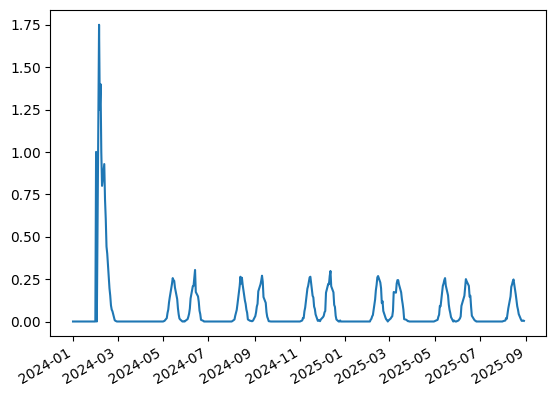

In [30]:
turnover_s1.plot()

<Axes: >

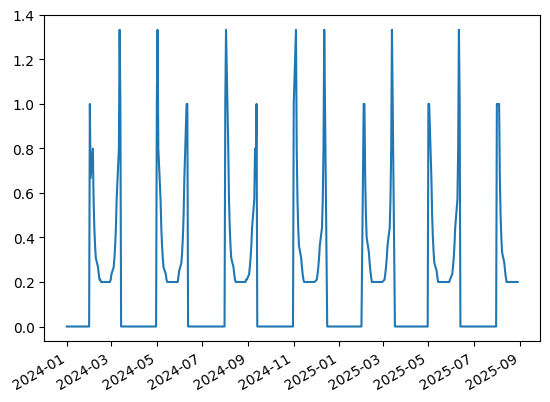

In [31]:
turnover_s2.plot()